В задании используется база курса акций Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда (только close) и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слои.


## Подготовка данных

Загрузка библиотек

In [2]:
# Работа с массивами
# Загрузка датасетов из облака google
import gdown
# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd
# Нормировщики
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Основные слои
from tensorflow.keras.layers import (LSTM, BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, Input, concatenate)
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Model, Sequential
# Оптимизаторы
from tensorflow.keras.optimizers import Adam
# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf

# Отрисовка графики в ячейке colab
%matplotlib inline


Назначение размера и стиля графиков по умолчанию

In [3]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка базы

In [4]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

Чтение и предварительная обработка данных

1. Загрузка данных из CSV-файлов
2. Объединение данных за разные годы
3. Удаление ненужных столбцов (дата и время)
4. Создание меток для каналов данных

In [5]:
# Чтение данных в таблицу pandas
base_data = pd.read_csv('16_17.csv', sep=';')

# Вывод первых строк таблицы
base_data.head()

# Загрузка датасетов с удалением ненужных столбцов по дате и времени

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])

# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17]).to_numpy()

# Задание текстовых меток каналов данных (столбцов)

channel_names = ['Open', 'Max', 'Min', 'Close', 'Volume']

Иллюстрация данных в графическом виде

Визуализация исходных данных

Построение графиков для визуального анализа временных рядов:
- Отображаются первые 300 точек начиная со 100-й
- На одном графике показаны цены Open, Max, Min и Close

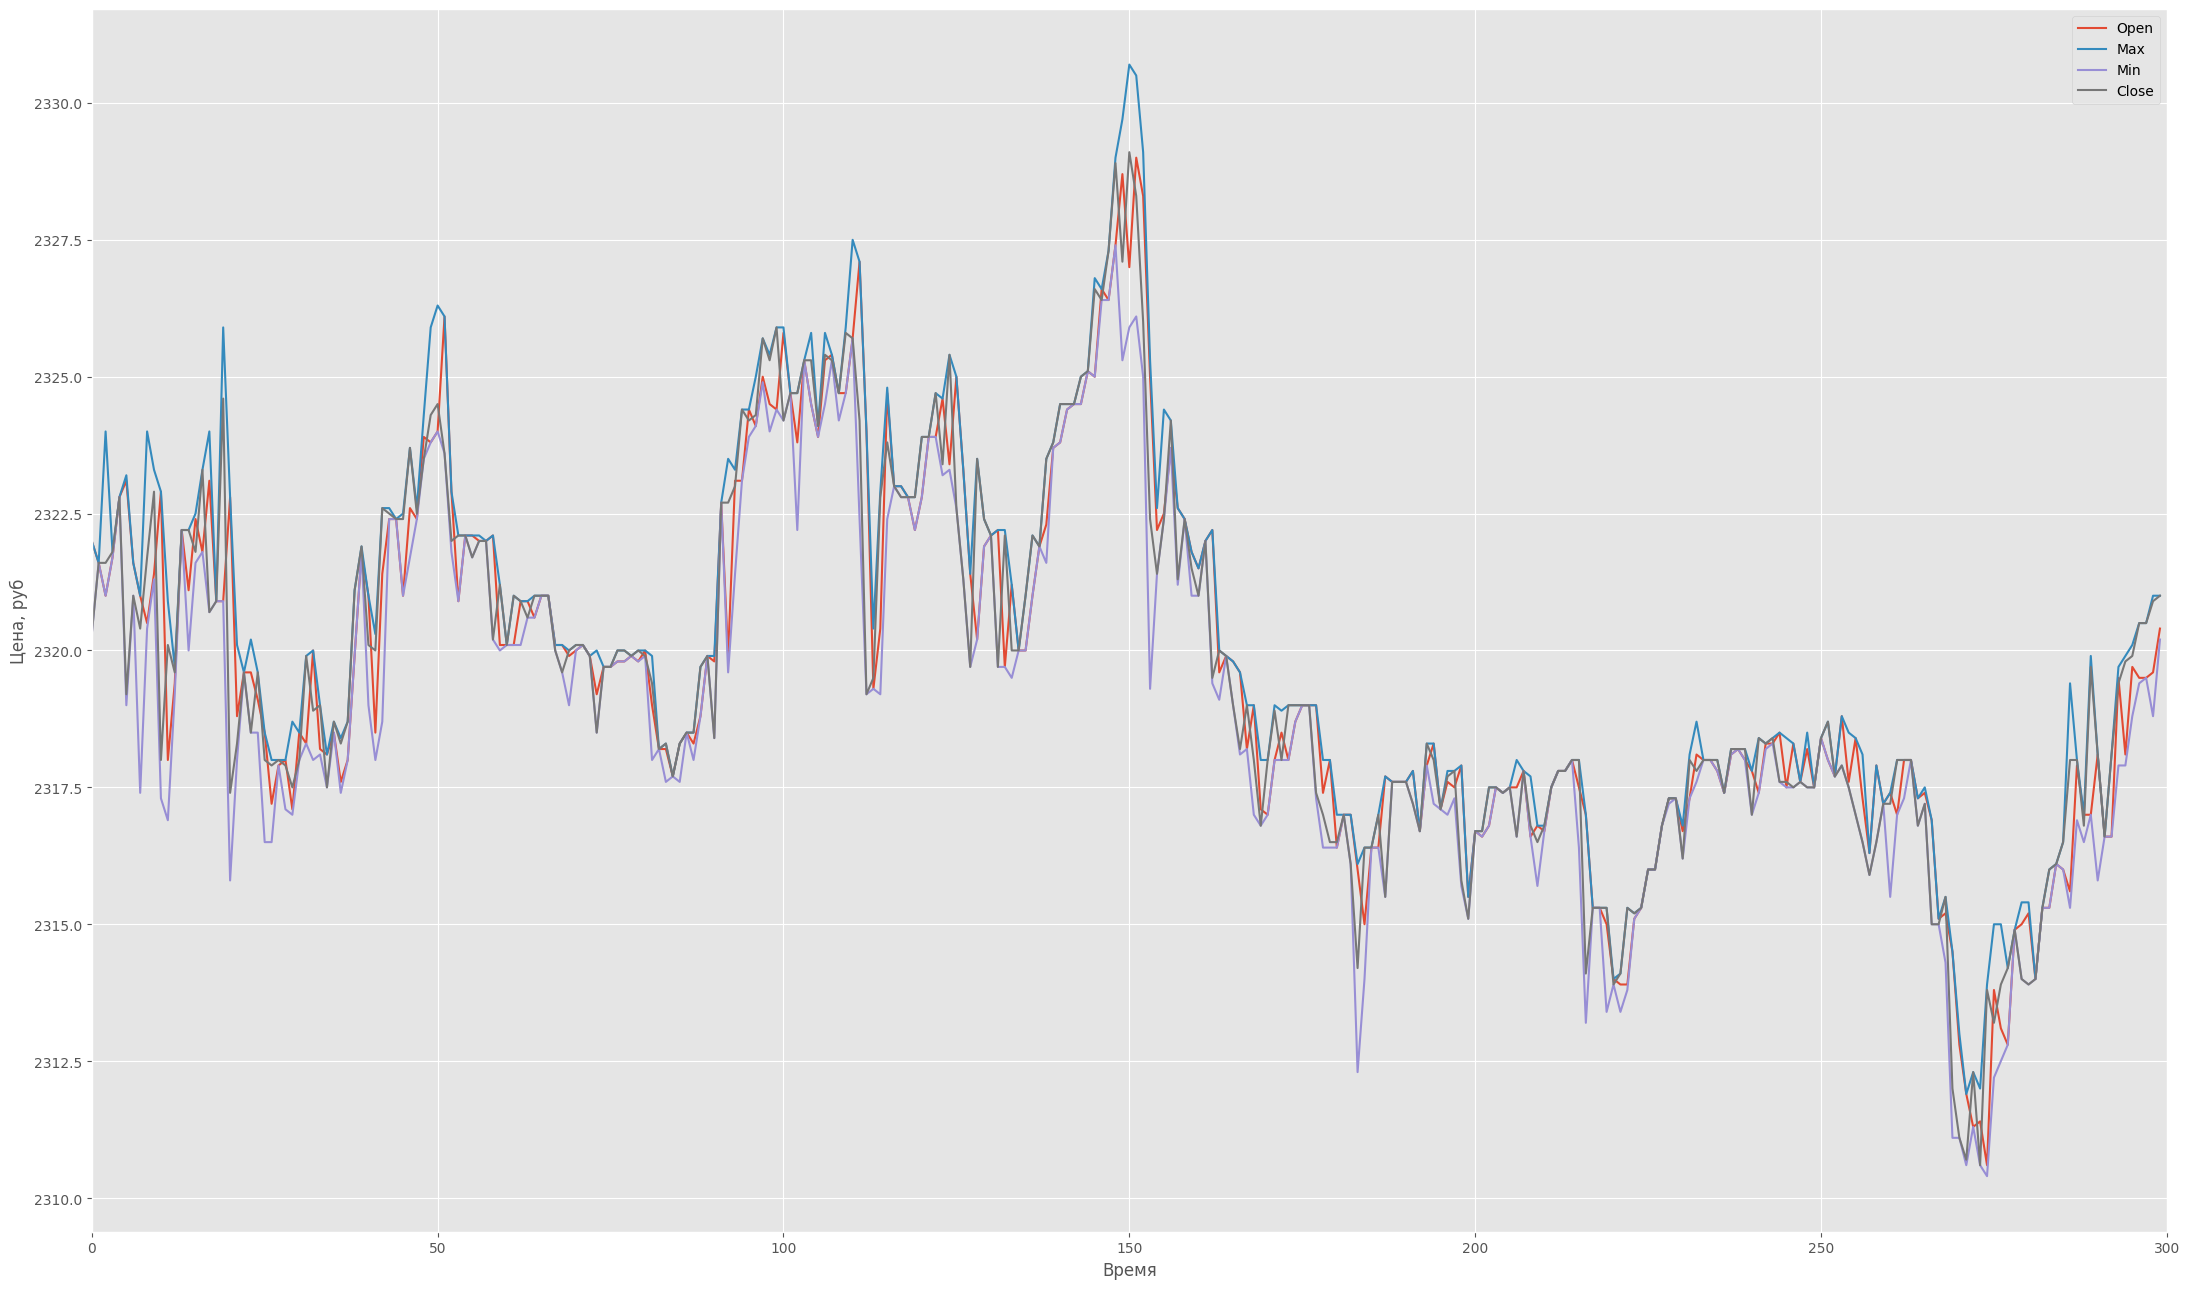

In [6]:
# Отображение исходных данных от точки start и длинной length
start = 100
length = 300

# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, ax = plt.subplots(figsize=(22, 13), sharex=True)

# Четыре основных канала - open, max, min, close
for chn in range(4):
    # Отрисовка одного канала данных
    # От начальной точки start длиной length
    ax.plot(data[start:start + length, chn],
             label=channel_names[chn])
ax.set_ylabel('Цена, руб')
ax.legend()
plt.xlabel('Время')

# Регулировка пределов оси x
plt.xlim(0, length)

# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()

# Фиксация графика
plt.show()

Создание словаря для доступа к каналам данных

Создается словарь, позволяющий получать индекс канала по его имени.
Это упрощает доступ к данным в дальнейшем.

In [7]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['Open', 'Max', 'Min', 'Close', 'Volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX)

{'Open': 0, 'Max': 1, 'Min': 2, 'Close': 3, 'Volume': 4}


Определение ключевых параметров для работы с временными рядами:
- Каналы для предсказания (Close)
- Длина последовательности для анализа (300 точек)
- Размер батча (20)
- Разделение на обучающую и тестовую выборки

In [8]:
# Задание гиперпараметров

CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
SEQ_LEN = 300                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 30000                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

Подготовка данных для обучения

1. Разделение данных на обучающую и тестовую выборки
2. Масштабирование данных с помощью MinMaxScaler
3. Создание генераторов временных рядов

In [9]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

# Разделение данных на тренировочный и тестовый наборы
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

[0, 1, 2, 3, 4] [3]
Train data: (233925, 5), (233925, 1)
Test  data: (29400, 5), (29400, 1)
Train batch x: (20, 300, 5), y: (20, 1)
Test x: (29100, 300, 5), y: (29100, 1)


Вспомогательные функции

Определение функций для:
1. Получения предсказаний модели
2. Визуализации результатов
3. Вычисления корреляций
4. Обучения и оценки моделей

In [10]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')


Функция обучения модели и отрисовки прогресса и оценки результатов

In [11]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

Простая полносвязная сеть

Создание и обучение базовой модели для прогнозирования временного ряда.
Архитектура:
- Входной полносвязный слой (32 нейрона)
- Выравнивающий слой
- Выходной слой с линейной активацией

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         9,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,793 (38.25 KB)

 Trainable params: 9,793 (38.25 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.0108 - val_loss: 1.3987e-04
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.6800e-04 - val_loss: 1.3325e-04
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.4734e-04 - val_loss: 1.0755e-04
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.3198e-04 - val_loss: 1.0152e-04
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 1.1190e-04 - val_loss: 1.0865e-04
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 9.8129e-05 - val_loss: 7.0046e-05
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 8.5549e-05 - val_loss: 7.5143e-05
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 7.7350e-05 - val_loss: 6.3220e-05
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 6.7968e-05 - val_loss: 5.9689e-05
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 6.3102e-05 - val_loss: 4.8495e

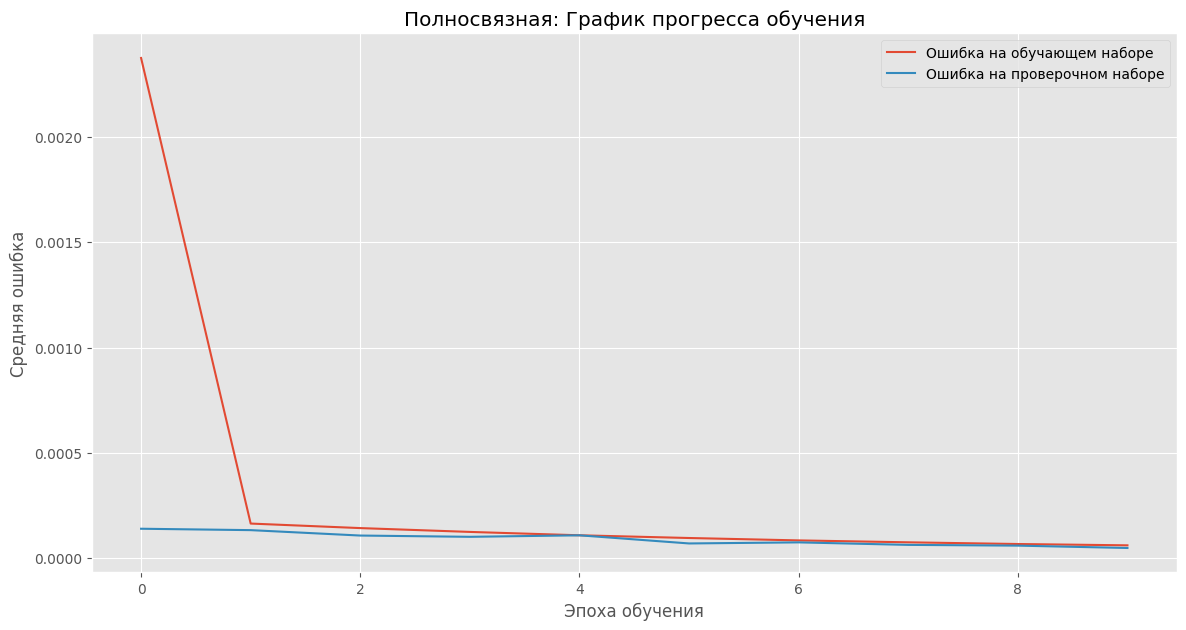

910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step


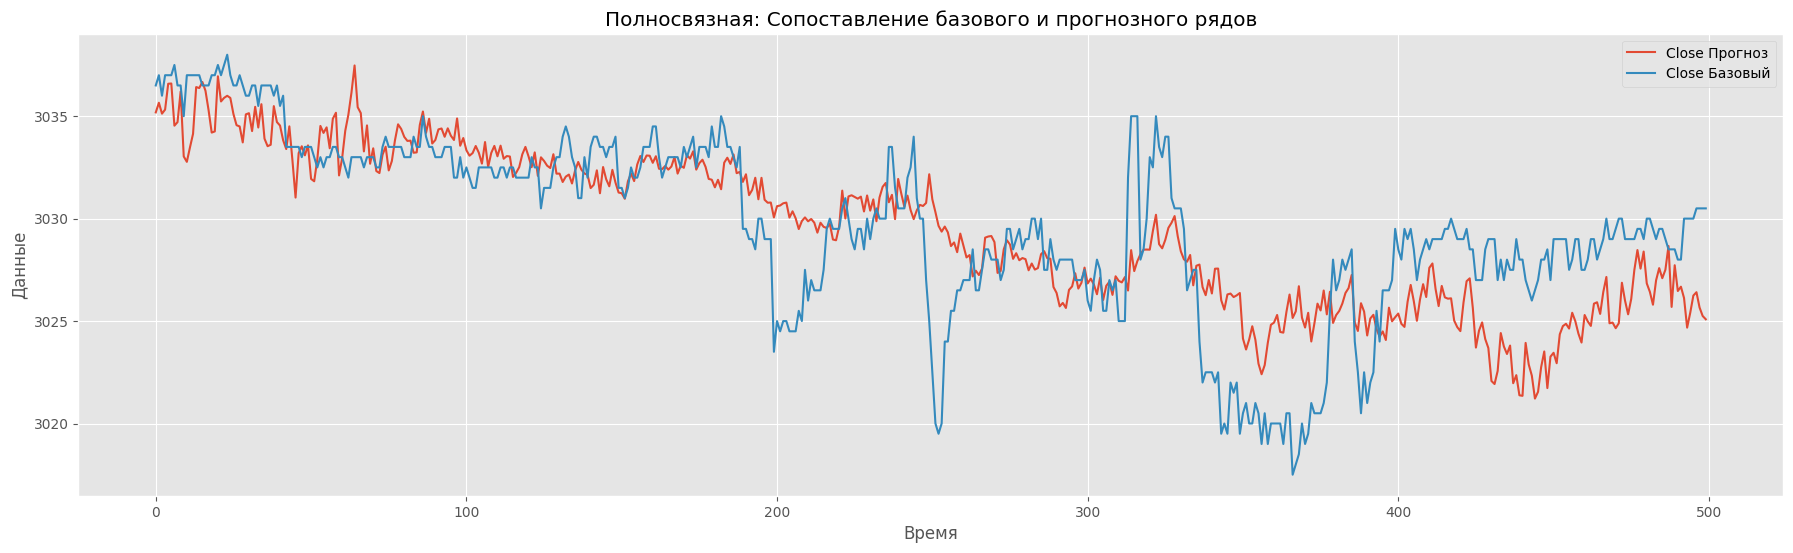

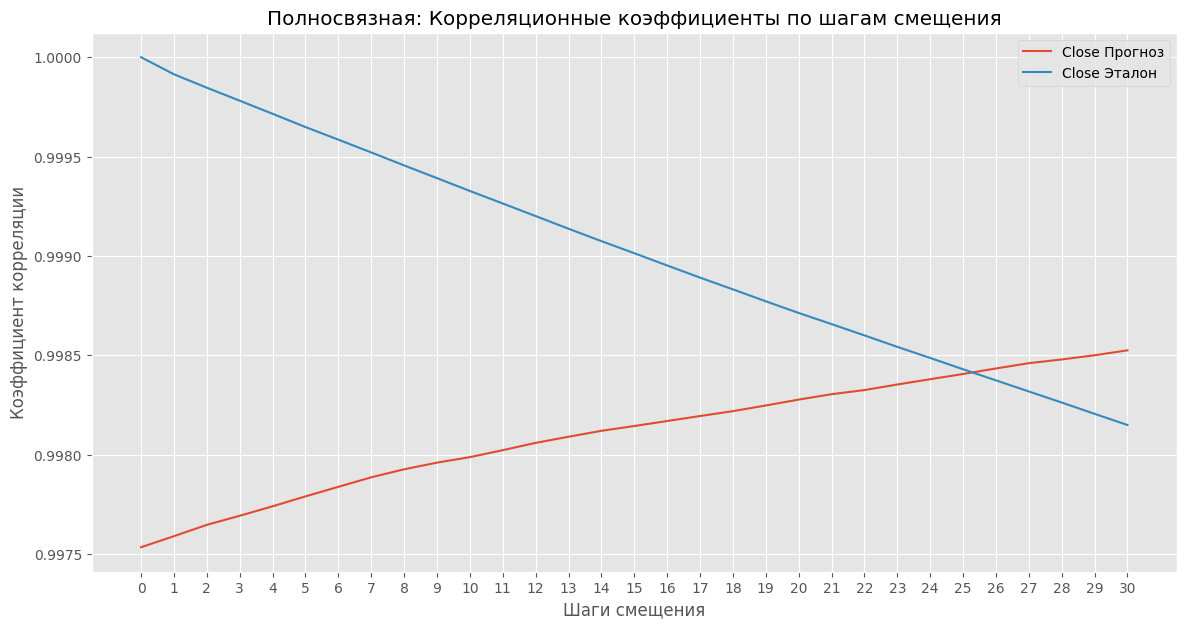

In [12]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(32, input_shape=x_test.shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(y_test.shape[1], activation='linear'))


with tf.device('/GPU:0'):
    # Обучение модели 10 эпох для ускорения
    train_eval_net(model_dense, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-6))],
                   x_test, y_test, y_scaler, title='Полносвязная')

Подготовка данных для многошагового прогноза

Модификация данных для прогнозирования на 10 шагов вперед:
1. Создание последовательностей выходных данных соответствующей длины
2. Обрезка входных данных для соответствия новым выходам
3. Создание новых генераторов временных рядов

In [ ]:
# Подготовка y_data для многошагового предсказания
def prepare_multi_step_y(y_data, seq_len, forecast_steps):
    y_sequences = []
    for i in range(len(y_data) - seq_len - forecast_steps + 1):
        y_sequences.append(y_data[i+seq_len : i+seq_len+forecast_steps])
    return np.array(y_sequences)

# Параметры для многошагового прогноза
FORECAST_STEPS = 10  # горизонт прогноза (количество шагов вперед)

# Формирование выходных последовательностей из y (функция уже определена в ноутбуке)
y_train_multi = prepare_multi_step_y(y_data_train, SEQ_LEN, FORECAST_STEPS)
y_test_multi  = prepare_multi_step_y(y_data_test,  SEQ_LEN, FORECAST_STEPS)

# Обрезка x_data до длины, соответствующей новым y_multi
x_train_multi = x_data_train[:len(y_train_multi)]
x_test_multi  = x_data_test[:len(y_test_multi)]

# Создаем генераторы временных рядов для обучения и проверки (batch_size как в базовом примере)
train_datagen_multi = TimeseriesGenerator(x_train_multi, y_train_multi, length=SEQ_LEN, batch_size=BATCH_SIZE)
val_datagen_multi   = TimeseriesGenerator(x_test_multi,  y_test_multi,  length=SEQ_LEN, batch_size=BATCH_SIZE)

# Проверяем форму данных из генератора
x_batch, y_batch = train_datagen_multi[0]

print(f"Shape of batch X: {x_batch.shape}, Y: {y_batch.shape}")
# Ожидаемый вывод: X: (BATCH_SIZE, SEQ_LEN, num_features), Y: (BATCH_SIZE, FORECAST_STEPS, num_targets)

# Создаем генератор тестовых данных для многошагового прогноза
test_datagen_multi = TimeseriesGenerator(
    x_test_multi,
    y_test_multi,
    length=SEQ_LEN,        # длина последовательности (должна совпадать с SEQ_LEN)
    stride=1,
    sampling_rate=1,
    batch_size=BATCH_SIZE  # размер батча (должен совпадать с BATCH_SIZE)
)

# Формирование тестовой выборки из генератора
x_test_full, y_test_full = test_datagen_multi[0]

# Проверка формы тестовой выборки
print(f'Test x (multi-step): {x_test_multi.shape}, y (multi-step): {y_test_multi.shape}')

Shape of batch X: (20, 300, 5), Y: (20, 10, 1)
Test x (multi-step): (29091, 5), y (multi-step): (29091, 10, 1)


Полносвязная модель для многошагового прогноза

Архитектура аналогична предыдущей, но выходной слой предсказывает 10 значений.
Обучение проводится на модифицированных данных.

In [ ]:
# Создание и обучение полносвязной модели для прогноза 10 шагов вперед
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(SEQ_LEN, x_train_multi.shape[1])))  # x_train_multi.shape[1] - число признаков на входе
model.add(Flatten())
model.add(Dense(FORECAST_STEPS, activation='linear'))  # выходной слой на 10 прогнозных значений

model.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model.summary()
with tf.device('/GPU:0'):
    history = model.fit(
        train_datagen_multi,
        validation_data=val_datagen_multi,
        epochs=10,
        verbose=1
    )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 300, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          96,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,202 (375.79 KB)

 Trainable params: 96,202 (375.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0128 - val_loss: 4.0835e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 5.3698e-04 - val_loss: 4.3908e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 5.2429e-04 - val_loss: 3.9370e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 5.1281e-04 - val_loss: 4.0271e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 5.0740e-04 - val_loss: 4.2164e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 4.9978e-04 - val_loss: 3.8153e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 5.0214e-04 - val_loss: 4.3320e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 4.9361e-04 - val_loss: 3.6248e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 4.7404e-04 - val_loss: 4.0876e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 4.6475e-04 - val_loss: 4.0696e-04


910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


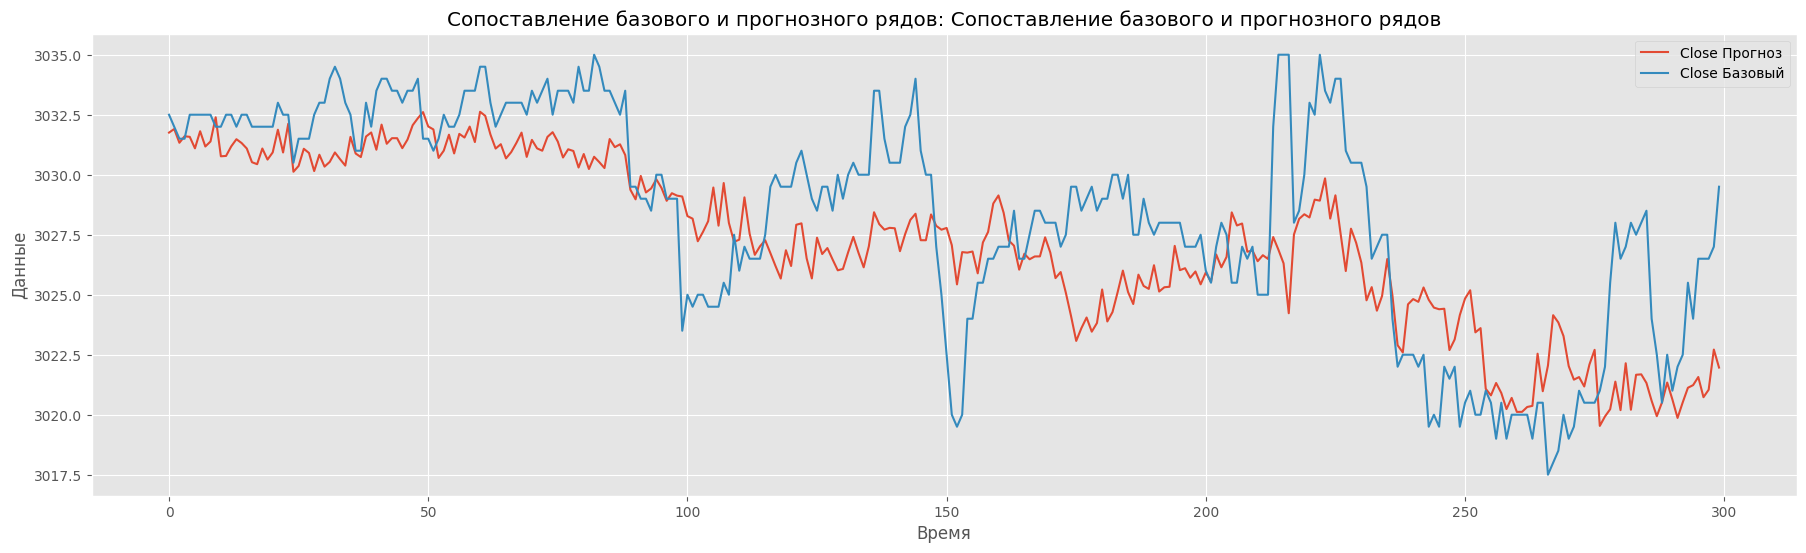

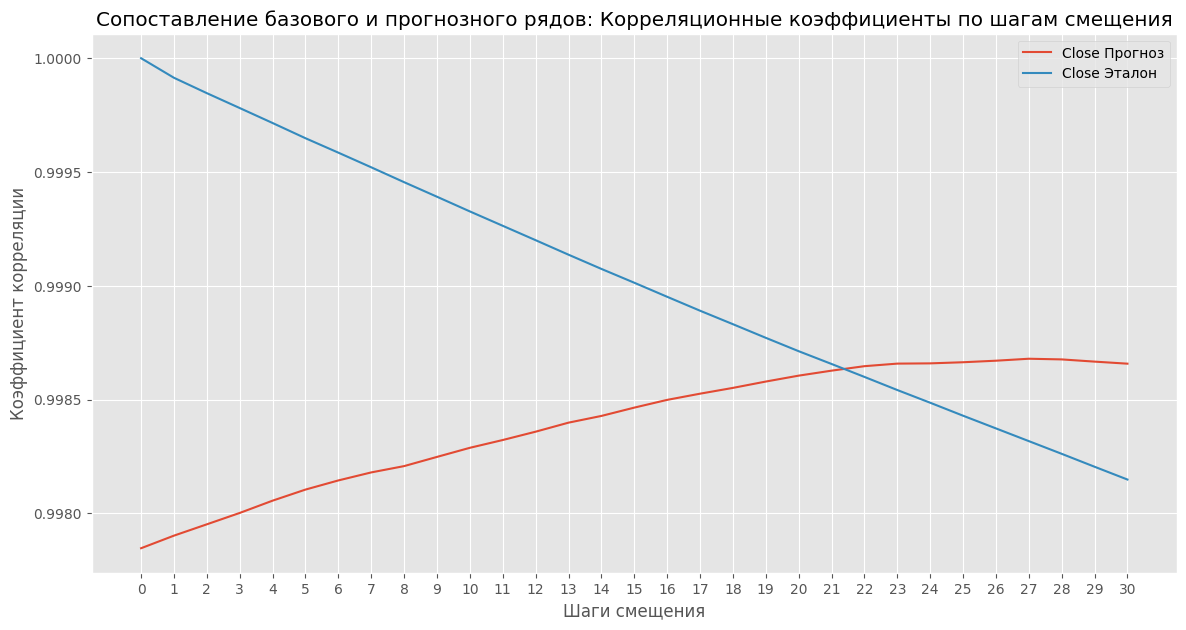

In [37]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

 Подготовка данных для визуализации многошагового прогноза

Преобразование предсказаний и истинных значений:
1. Получение предсказаний в масштабе [0,1]
2. Изменение формы данных для денормализации
3. Обратное преобразование к исходному масштабу

In [38]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Визуализация прогнозов для каждого шага

Построение 10 графиков (по одному на каждый шаг прогноза) для сравнения:
- Истинные значения
- Предсказания модели

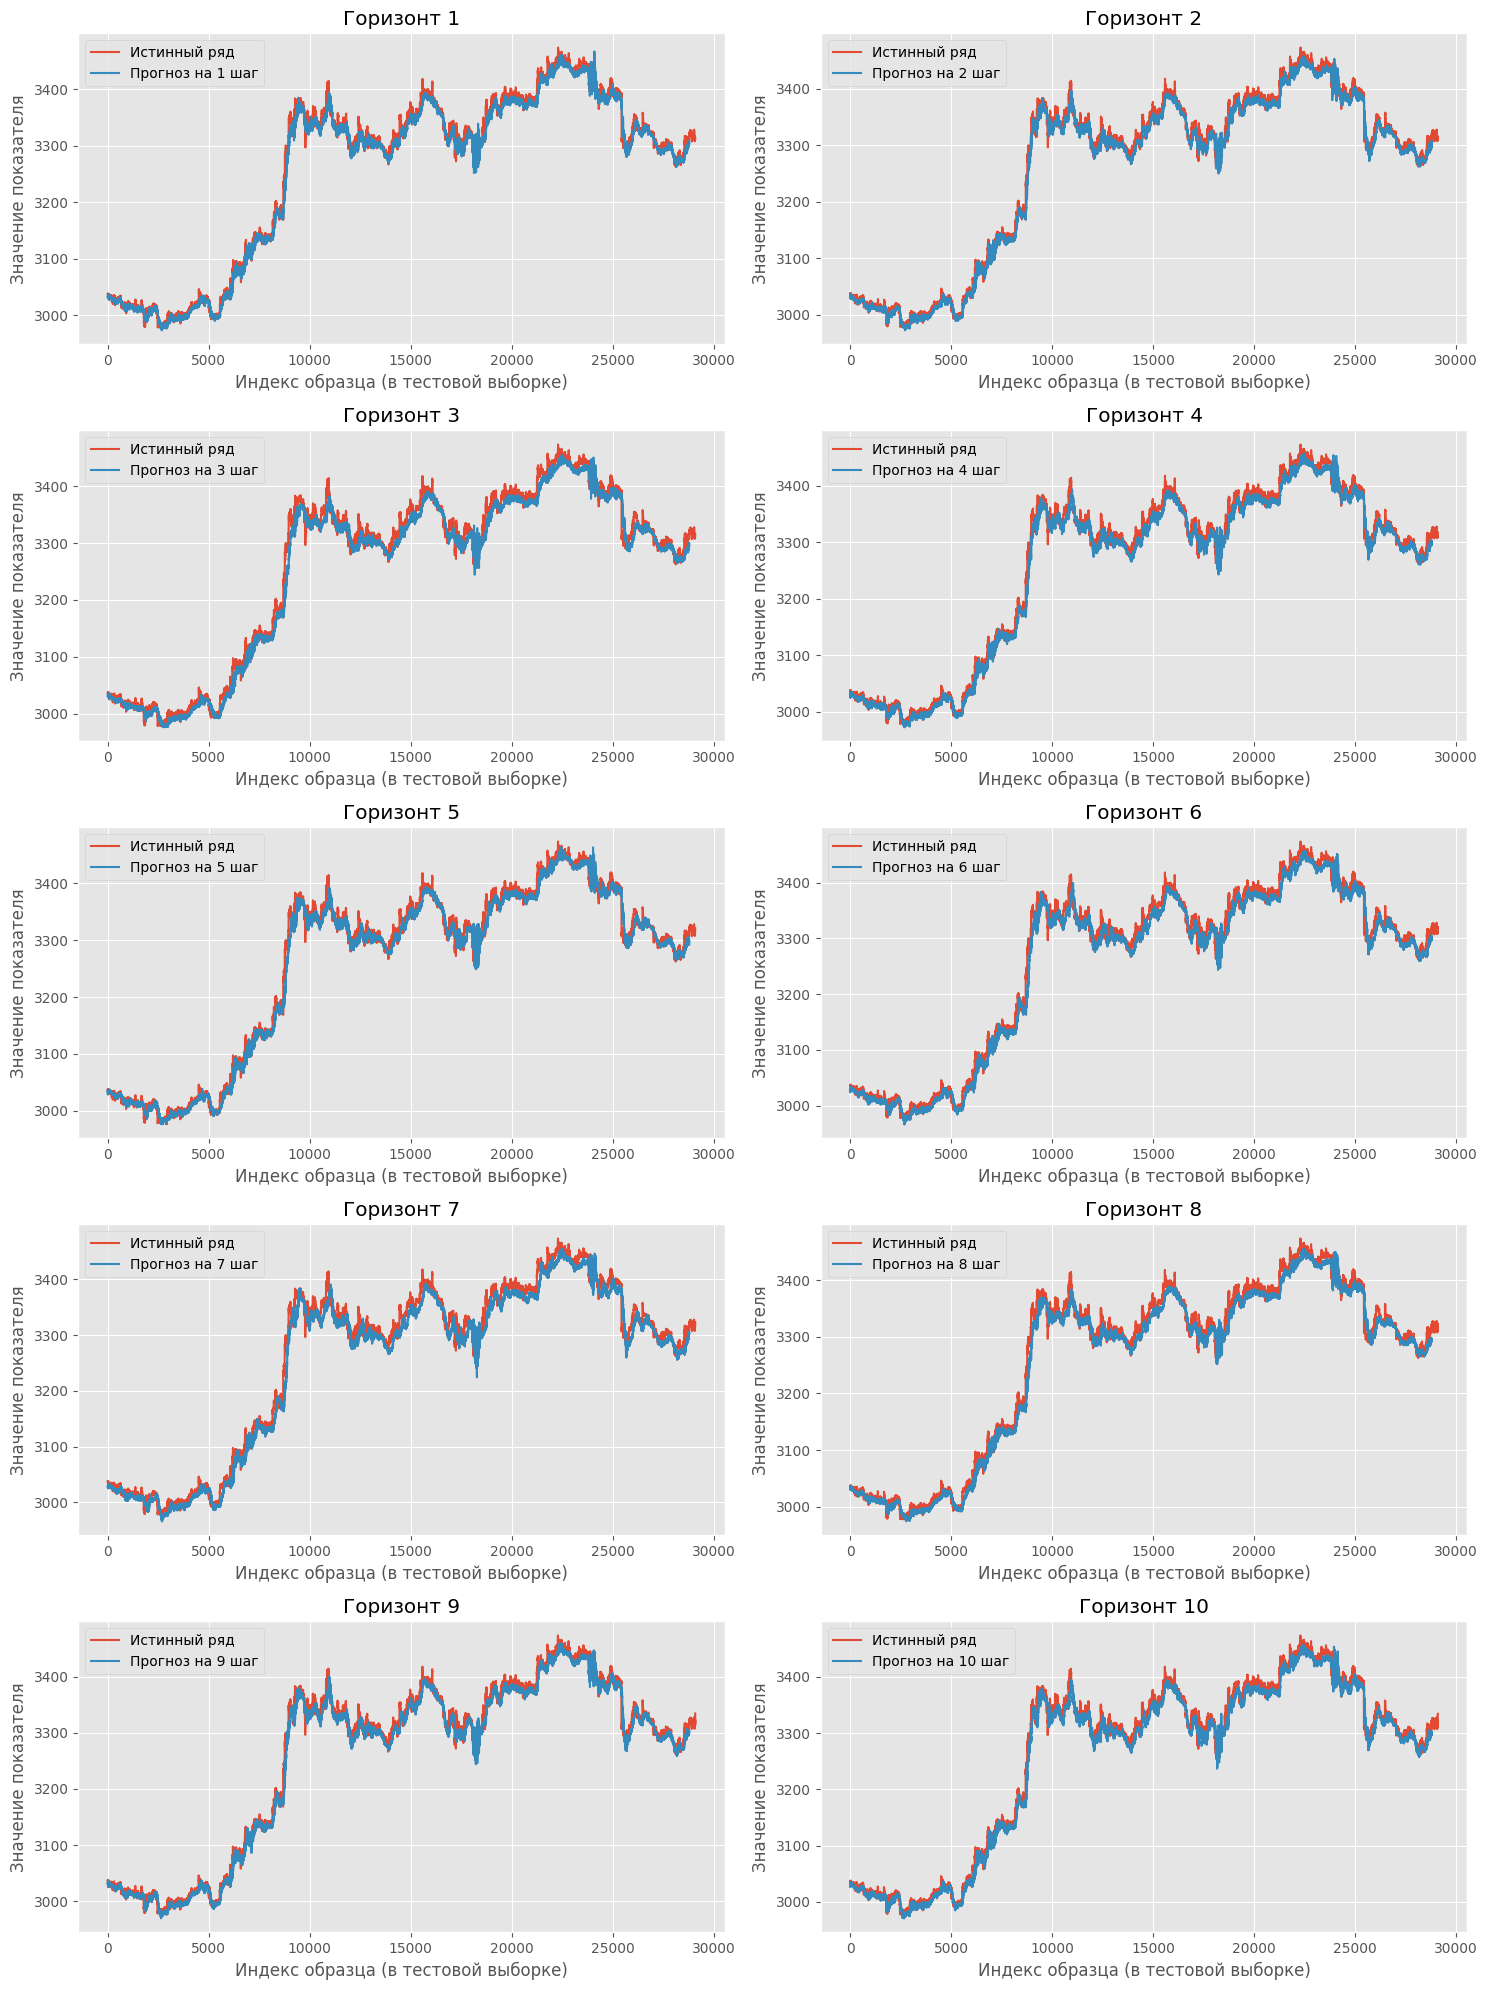

In [39]:
# Построение 10 графиков: истинные и предсказанные значения для каждого горизонта прогноза
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)  # размещаем графики в сетке 5x2
    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()

 Модель с одномерной сверткой

Архитектура:
- Сверточный слой (50 фильтров, размер ядра 5)
- Выравнивающий слой
- Полносвязные слои

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 296, 50)             │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 14800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │         148,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,321 (583.29 KB)

 Trainable params: 149,321 (583.29 KB)

 Non-trainable params: 0 (0.00 B)

Обучение 10 эпох
Epoch 1/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0146 - val_loss: 4.4845e-04
Epoch 2/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 1.7808e-04 - val_loss: 6.7378e-06
Epoch 3/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 5.1215e-05 - val_loss: 5.9067e-06
Epoch 4/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 3.5767e-05 - val_loss: 1.5249e-05
Epoch 5/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 3.2973e-05 - val_loss: 1.0002e-04
Epoch 6/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.3233e-05 - val_loss: 1.7612e-05
Epoch 7/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 2.7597e-05 - val_loss: 5.2825e-05
Epoch 8/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.6295e-05 - val_loss: 4.2905e-06
Epoch 9/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.5005e-05 - val_loss: 1.8737e-05
Epoch 10/10
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.0810e-05 - val_loss: 2.5132e

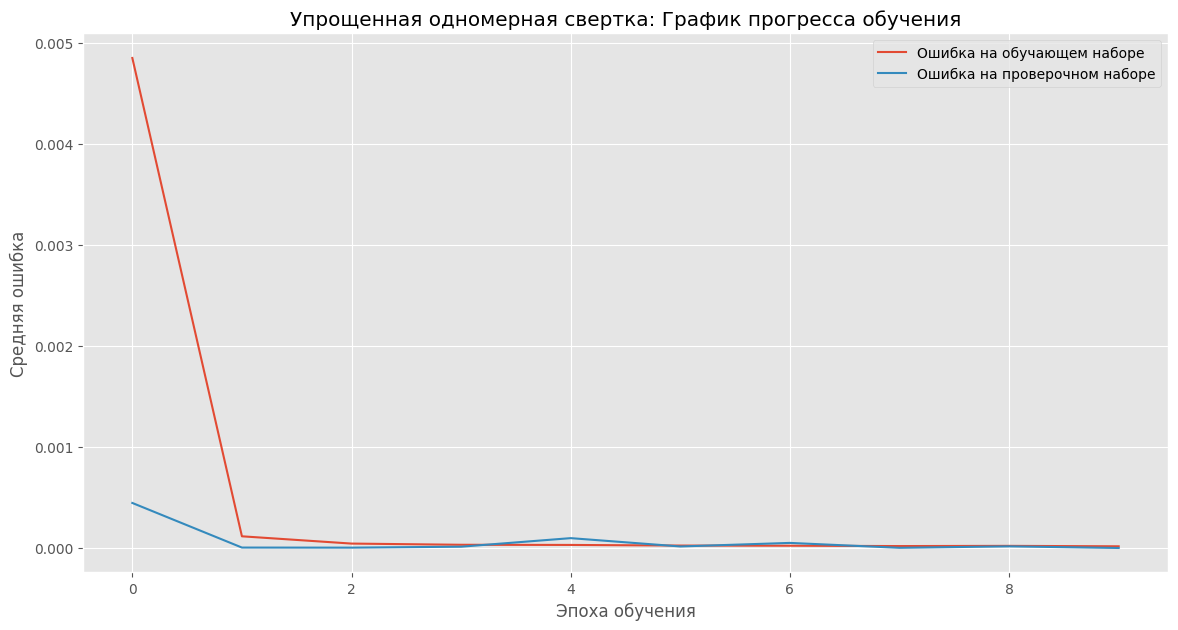

910/910 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


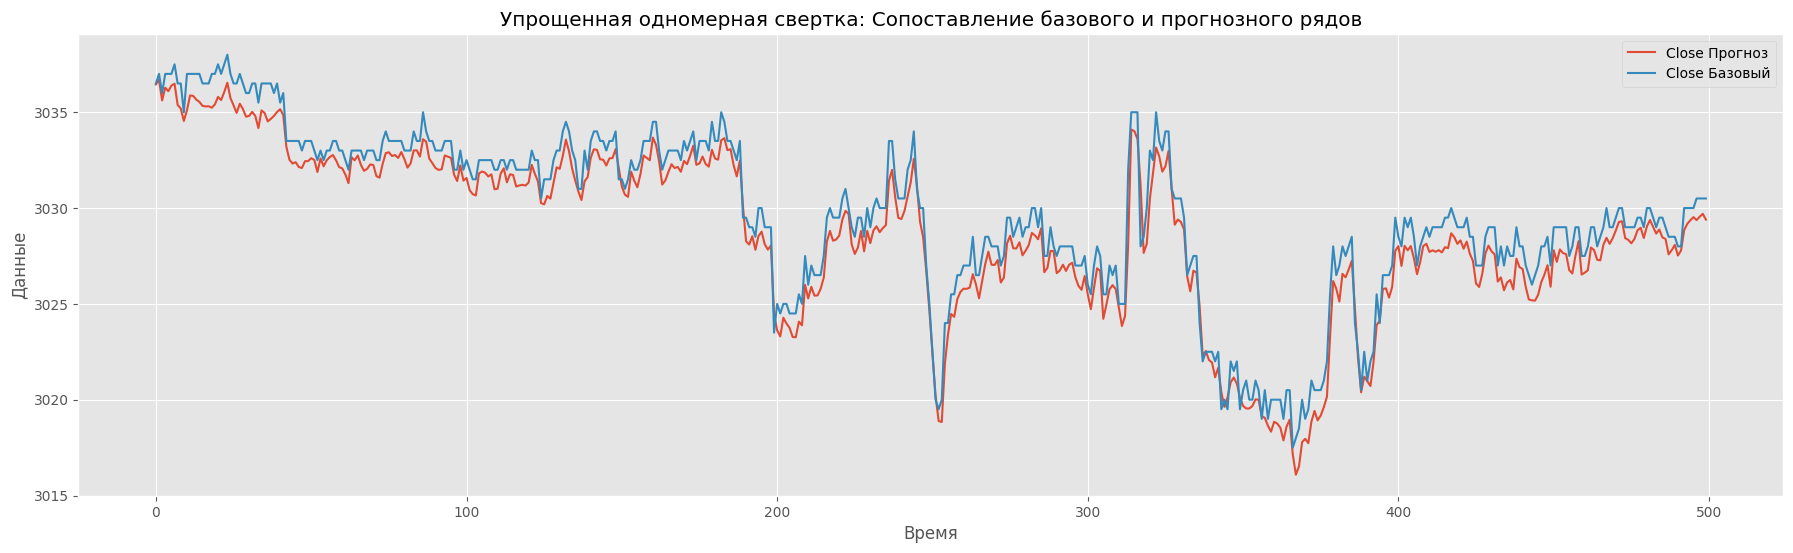

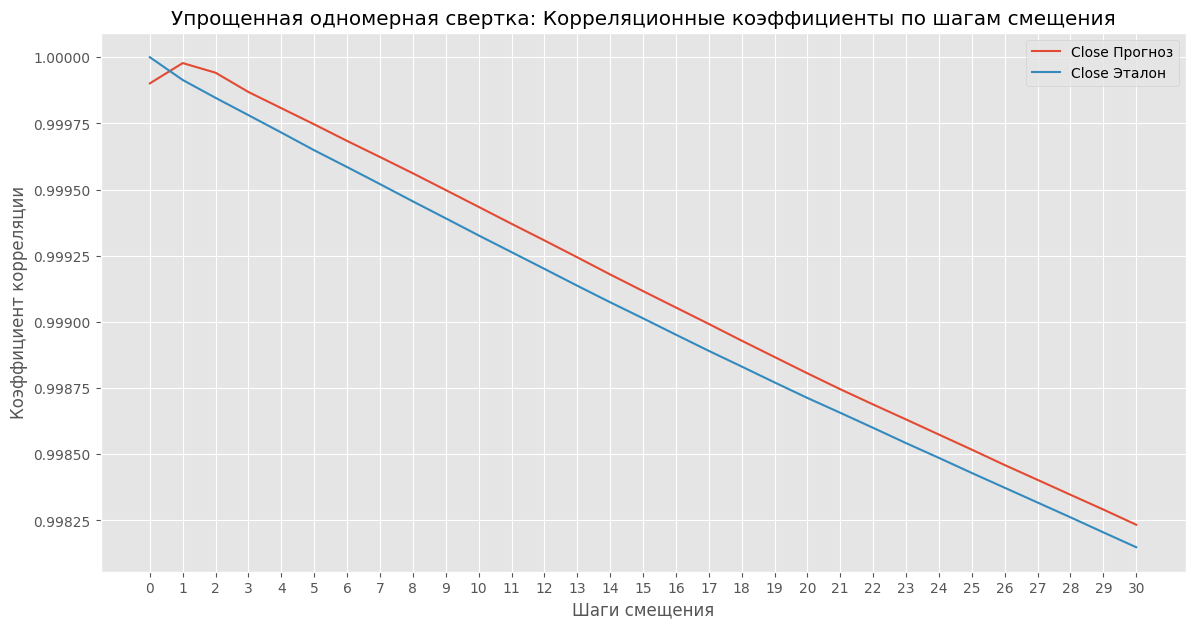

In [33]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))
with tf.device('/GPU:0'):
    # Обучение модели 10 эпох
    train_eval_net(model_conv_2, train_datagen, val_datagen, [(10, Adam(learning_rate=1e-4))],
                   x_test, y_test, y_scaler, title='Упрощенная одномерная свертка')

Сверточная модель для многошагового прогноза

Модификация сверточной модели для предсказания 10 шагов.
Архитектура аналогична, но выходной слой предсказывает 10 значений.

In [40]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(FORECAST_STEPS, activation='linear'))

model_conv_2.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
model_conv_2.summary()

history = model_conv_2.fit(
    train_datagen_multi,
    validation_data=val_datagen_multi,
    epochs=10,
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 296, 50)             │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 14800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │         148,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             110 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,420 (583.67 KB)

 Trainable params: 149,420 (583.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0291 - val_loss: 4.9804e-04
Epoch 2/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 5.5848e-04 - val_loss: 3.9290e-04
Epoch 3/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 5.1235e-04 - val_loss: 3.8057e-04
Epoch 4/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 5.0349e-04 - val_loss: 3.9499e-04
Epoch 5/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 4.9306e-04 - val_loss: 4.0097e-04
Epoch 6/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 5.0033e-04 - val_loss: 4.0823e-04
Epoch 7/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 4.8192e-04 - val_loss: 3.7156e-04
Epoch 8/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 4.9580e-04 - val_loss: 3.5712e-04
Epoch 9/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 4.6929e-04 - val_loss: 3.6597e-04
Epoch 10/10
11666/11666 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 4.7068e-04 - val_loss: 4.5144e-04


910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


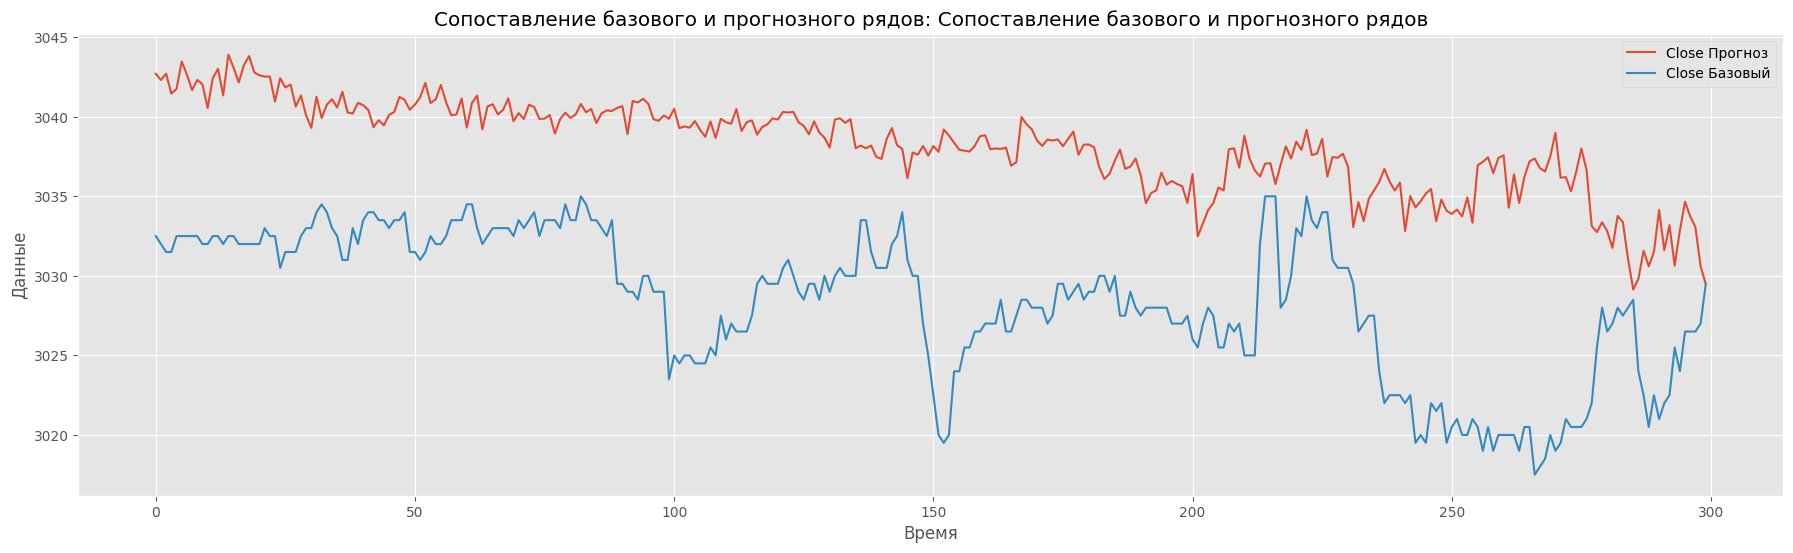

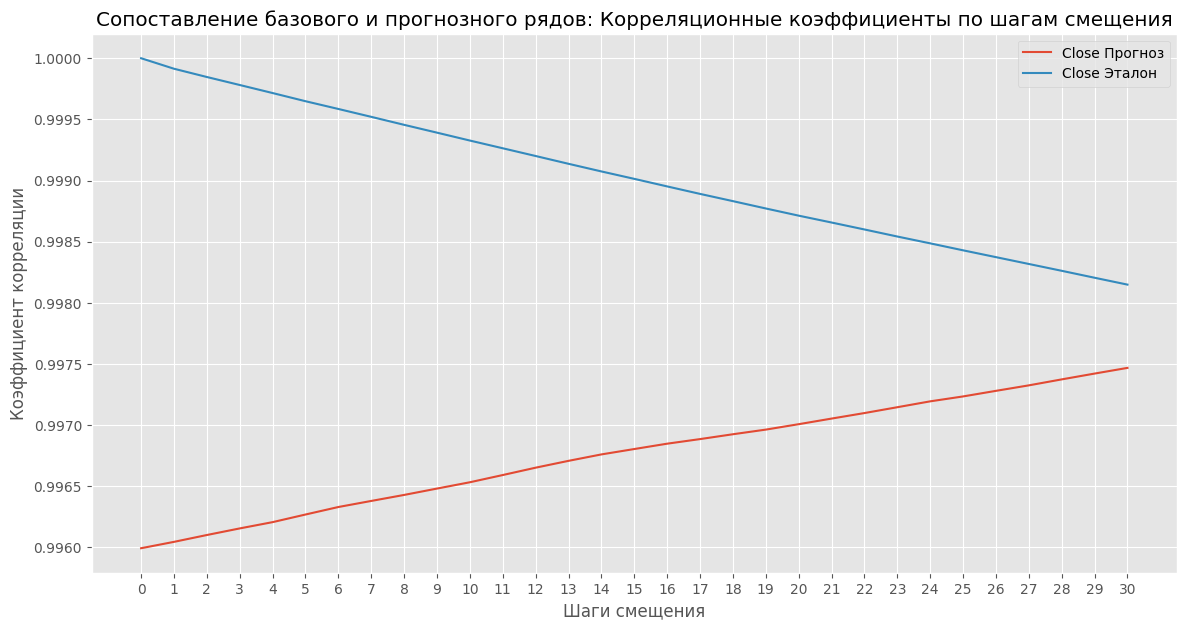

In [44]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv_2, x_test, y_test, y_scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
# Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
title = 'Сопоставление базового и прогнозного рядов'
show_predict(y_pred[1:], y_true[:-1], start, length, title=f'{title}: Сопоставление базового и прогнозного рядов')

# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, back_steps_max=30, title=f'{title}: Корреляционные коэффициенты по шагам смещения')

Подготовка данных для визуализации 

Преобразование предсказаний и истинных значений для сверточной модели.

In [45]:
# Получение предсказаний на тестовой выборке (в масштабе [0,1])
y_pred_scaled = model_conv_2.predict(test_datagen_multi)  # форма (N, 10)

# Преобразование предсказаний и правильных ответов обратно в исходный масштаб
# Для использования scaler необходимо подать данные в двумерном формате
y_pred_reshaped = y_pred_scaled.reshape(-1, 1)              # раскладываем все 10 шагов в одну колонку
y_test_reshaped = y_test_multi.reshape(-1, 1)               # аналогично раскладываем истинные значения

y_pred_unscaled = y_scaler.inverse_transform(y_pred_reshaped).reshape(-1, FORECAST_STEPS)
y_test_unscaled = y_scaler.inverse_transform(y_test_reshaped).reshape(-1, FORECAST_STEPS)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Визуализация многошагового прогноза (сверточная модель)

Построение 10 графиков для сравнения предсказаний на каждый шаг.

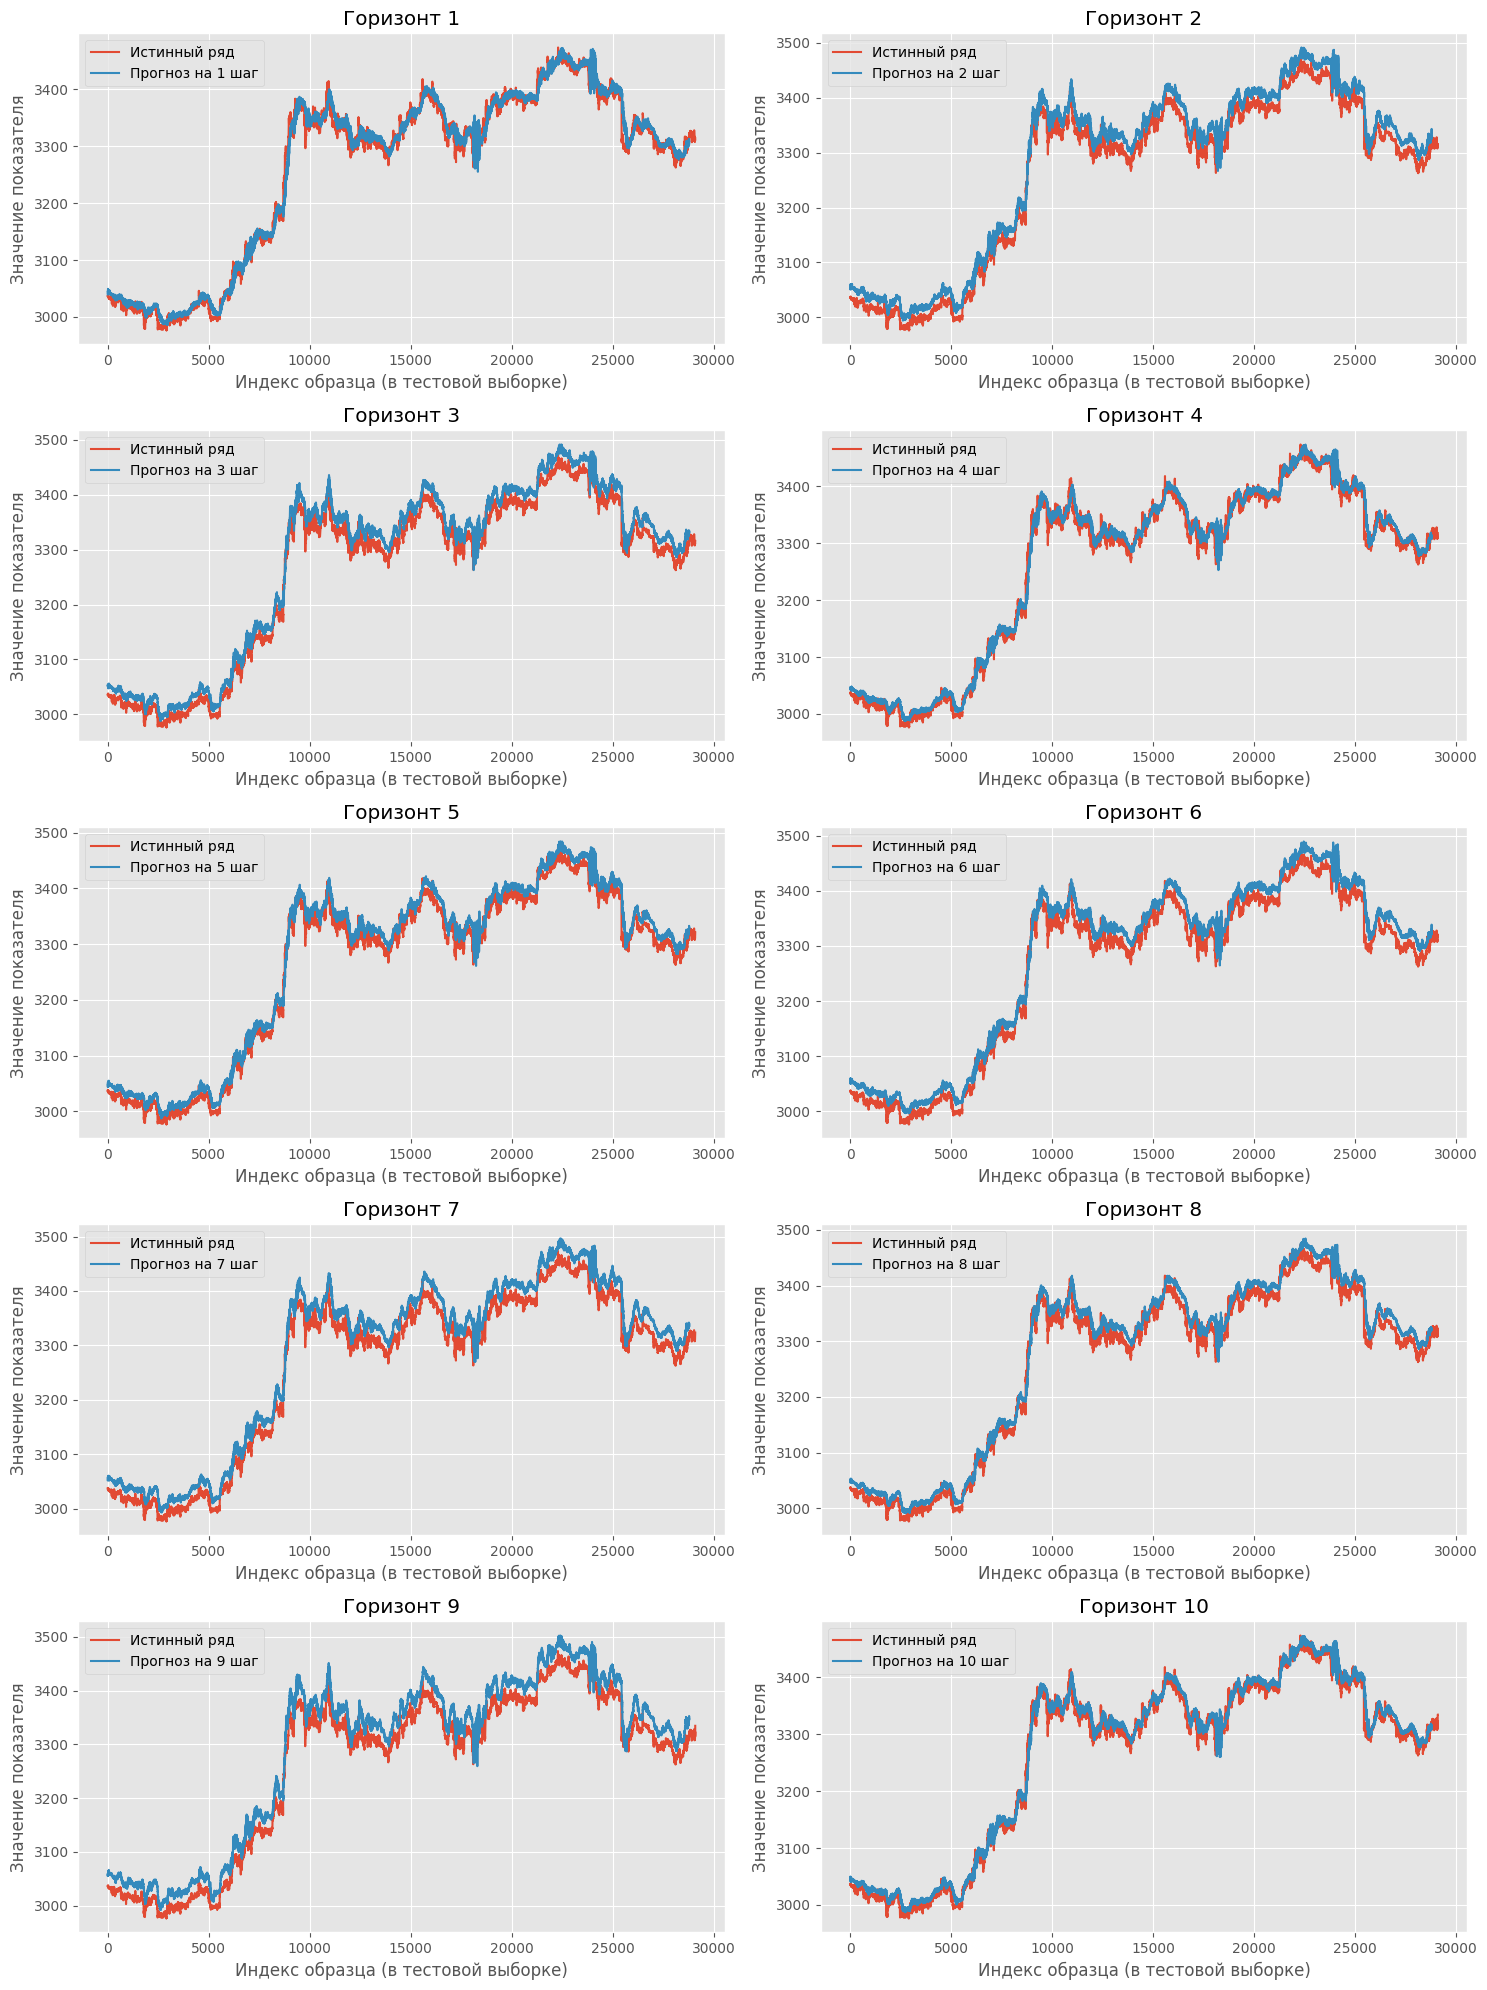

In [46]:
# Построение 10 графиков: истинные и предсказанные значения для каждого горизонта прогноза
plt.figure(figsize=(15, 20))
for h in range(FORECAST_STEPS):
    plt.subplot(5, 2, h+1)  # размещаем графики в сетке 5x2
    # Определяем соответствующий горизонт (h+1 шагов вперед)
    true_series = y_test_unscaled[:, h]
    pred_series = y_pred_unscaled[:, h]
    plt.plot(true_series, label='Истинный ряд')
    plt.plot(pred_series, label='Прогноз на {} шаг'.format(h+1))
    plt.title(f'Горизонт {h+1}')
    plt.xlabel('Индекс образца (в тестовой выборке)')
    plt.ylabel('Значение показателя')
    plt.legend()
plt.tight_layout()
plt.show()